# Data Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
pathtohere = Path()

In [2]:
from pyDataAnalysis.readData import *

from pyDataAnalysis.photon import Photon
from pyDataAnalysis.Zboson import Zboson
from pyDataAnalysis.Worders.Wboson_LO import Wboson_LO

In [3]:
def display_PDFs(xs:np.ndarray, data:np.ndarray, headings:tuple,colours:tuple,q:float, momFrac:int):
    """
    Display the PDFs.
    
    Inputs:
        - xs:np.ndarray: Momentum fractions the PDFs are evaluated at.
        - data:np.ndarray: 2D array of PDFs of each used quark at all x.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - q:float: Q evaluated at.
        - momFrac:int: Momentum fraction index 1/2.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    divider = 1.
    
    for i,heading in enumerate(headings):
        if '/' in heading:
            divider = float(heading.split('/')[1])
        ax.plot(xs, data[:, i] / divider, label=heading,c=colours[i],marker='.')
        ax.grid()
    
    # Create appropiate labels.
    ax.set_xlabel(f'momentum fraction / x_{momFrac}')
    ax.set_ylabel(r'PDF / $f_i(x)$')
    ax.set_title(r'$Q$ =' + str(q))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()
    
    

### Cross section calculations
Using $x_2 = \frac{M^2}{sx_1}$, $y = \frac{1}{2}\ln\Big(\frac{x_1}{x_2}\Big)$, $\tilde{f}_q(x_i) = x_if_q(x_i)$

#### $\gamma$
$$
\sigma_{\gamma} = \int dM^2 \int dy\frac{4\pi\alpha^2}{3M^2}\frac{1}{Ns} \sum\limits_{q}\frac{Q^2_q}{x_1x_2} \Big(\tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2) + \tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2)\Big)
$$
#### W
$$
\sigma_W = \int dy \frac{\pi}{Ns}\sqrt{2}G_F|M_W^2||V_{q\bar{q}}|^2\frac{1}{x_1x_2} \sum\limits_{q_1}\sum\limits_{q_2}\Big(\tilde{f}_{q_1}(x_1)\tilde{f}_{\bar{q_2}}(x_2) + \tilde{f}_{\bar{q_1}}(x_1)\tilde{f}_{q_2}(x_2)\Big)
$$
#### Z
$$
\sigma_Z = \int dy \frac{\pi}{Ns}\sqrt{2}G_F|M_Z^2|(|V_{q\bar{q}}|^2 + |A_q|^2) \frac{1}{x_1x_2}\sum\limits_{q}\Big(\tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2) + \tilde{f}_q(x_1)\tilde{f}_{\bar{q}}(x_2)\Big)
$$

$$
\cos\theta^* = \frac{e^{2y^*} - 1}{e^{2y^*} + 1}
$$
$$
1\pm\cos\theta^* = \frac{e^{2y^*} + 1}{e^{2y^*} + 1} \pm \frac{e^{2y^*} - 1}{e^{2y^*} + 1} = \frac{2e^{2y^*}}{e^{2y^*} + 1},\frac{2}{e^{2y^*} + 1}
$$
$$
\frac{dy}{d\cos\theta} = \frac{1+\cos^2\theta}{2(1-\cos\theta)(1+\cos\theta)}
$$
$$
\frac{d\cos\theta}{dy} = 2e^{2y}\frac{2}{(e^{2y}+1)^2}
$$

$$
p_T = \frac{M_W}{2}\sqrt{1 - \cos^2\theta}
$$
$$
\frac{d\cos\theta}{dp_T} = -\frac{4p_T}{M_W^2}(1-\frac{4p_T^2}{M_W^2})^{-\frac{1}{2}}
$$


$$
y^* = \frac{1}{2}\ln\Big( \frac{1+\cos\theta}{1 - \cos\theta} \Big) \,\,;\, \theta\in[0,\pi)
$$
$$
y_e = y_W + y^*
$$

$$
\frac{d\sigma}{dy_e} = \int dy_W \frac{d\sigma}{dy_W} (y_W+y^*)
$$

| Sign | $W^+$ | $W^-$ |
| --- | --- | --- |
| Particle $x_1$ | - | + |
| Antiparticle $x_1$ | + | - |

In [4]:
from pyDataAnalysis.crossSection import *

LHC_s = (7e+3)**2 # [GeV^2] 
CKM = np.asarray([[0.97373, 0.2243, 0.00382], [0.221, 0.975, 0.0408], [0.0086, 0.0415, 1.014]]) 
fermiConstant = 1.1663788e-5 # [GeV^-2] # https://arxiv.org/abs/1010.0991
fineStructure = 1/137
electronCharge = 1.6e-19
alpha_s = 1.

BR_W_enu = 0.1083 # https://arxiv.org/abs/2201.07861

class Wboson_NLO(CrossSection):
    def __init__(self, WmassSqrd:float,
                 data1:np.ndarray, data2:np.ndarray,x1:np.ndarray,
                 x2s:np.ndarray,qs:np.ndarray,W_index:int):
        """
        Initialise the class.
        
        Inputs:
            - WmassSqrd:float: Squared mass of the W boson.
            - ZmassSqrd:float: Squared mass of the Z boson.
            - data1:np.ndarray: PDFS associated with x1 (Q, x, PDF).
            - data2:np.ndarray: PDFS associated with x2 (Q, x, PDF).
            - x1:np.ndarray: Momentum fractions for proton 1.
            - x2s:np.ndarray: Momentum fractions for proton 2 at all Q.
            - qs:np.ndarray: Qs evaluated at.
            - W_index:int: Index of data for the W boson Q.
        """
        
        CrossSection.__init__(self,data1,data2,x1,x2s,qs)
        
        self.x2 = x1
        self.s_hat = LHC_s*self.x1[:,None]*self.x2[None,:]

        self.num_pT = 50
        self.WmassSqrd = WmassSqrd
        
#         self.pTs = np.linspace(10,
#                (self.s_hat[-1,-1]-self.WmassSqrd) / (2*np.sqrt(self.s_hat[-1,-1])),self.num_pT)
        self.pTs = np.linspace(10,500,self.num_pT)
#         self.pTs = np.linspace(1,20,self.num_pT)


        epsilon = 0.2 * self.pTs[None,None,:]
        self.threshold = self.pTs[None,None,:] + np.sqrt(self.WmassSqrd + self.pTs[None,None,:]**2) + epsilon
                 
        self.W_index = W_index
        
        self.W_dx1dx2dpT = {
            '+' : None,
            '-' : None
        }
        self.W_dpT = {
            '+' : None,
            '-' : None
        }
        
        self.W_dye = {
            '+' : None,
            '-' : None
        }
        self.W_dye_int = {
            '+' : None,
            '-' : None
        }
        
    def calculate_W_dx1dx2dpT(self, Wcharge:str):
        """
        Calculate the W boson contribution to the cross-section as a function of
        x1, x2 and transverse momentum.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
        """
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."
        

        upTypePDFs = self.data[:,self.W_index,:,self.upType_i]
        downTypePDFs = self.data[:,self.W_index,:,self.downType_i]
        upTypeBarPDFs = self.data[:,self.W_index,:,self.upTypeBar_i]
        downTypeBarPDFs = self.data[:,self.W_index,:,self.downTypeBar_i]
        
        gluonPDF = self.data[:,self.W_index,:,self.gluon_i]
        
        # Set x2 PDFs to x1 PDFs.
        upTypePDFs[1] = upTypePDFs[0]
        downTypePDFs[1] = downTypePDFs[0]
        upTypeBarPDFs[1] = upTypeBarPDFs[0]
        downTypeBarPDFs[1] = downTypeBarPDFs[0]
        gluonPDF[1] = gluonPDF[0]
        
        
        
        # Derived expressions
        whereInvalid = np.where(np.sqrt(self.s_hat[:,:,None]) < self.threshold)

        costheta = -np.sqrt(1 - 4*self.pTs[None,None,:]**2 *self.s_hat[:,:,None] 
                           / (self.s_hat[:,:,None]-self.WmassSqrd)**2)

        
        if np.any(costheta>0):
            raise Exception('There are elements of costheta>0.')

        
        dsigma_dpT_qq = (16*fineStructure**2*alpha_s
                        *electronCharge**2*((self.WmassSqrd*self.WmassSqrd + self.s_hat[:,:,None]
                           *(self.s_hat[:,:,None] - 2*self.pTs[None,None,:]**2))
                        / (27*self.pTs[None,None,:]*self.WmassSqrd
                           *(self.WmassSqrd - self.s_hat[:,:,None])*self.s_hat[:,:,None]**2*costheta)))
        
        
        dsigma_dpT_qg = ((2*fineStructure**2*alpha_s
                          *electronCharge**2*self.pTs[None,None,:] *(-3*self.WmassSqrd*self.WmassSqrd 
                          + 2*self.pTs[None,None,:]**2 * self.s_hat[:,:,None]
                          + 4*self.WmassSqrd* self.s_hat[:,:,None] - 3*self.s_hat[:,:,None]**2
                          + (self.WmassSqrd*self.WmassSqrd + self.s_hat[:,:,None]**2)* costheta))
                            /(9*self.WmassSqrd *(self.WmassSqrd - self.s_hat[:,:,None])**2 * self.s_hat[:,:,None]**2
                                                     * costheta* (1 + costheta)))
        
        # Set unphysical cs to zero.
        dsigma_dpT_qq[whereInvalid] = 0.
        dsigma_dpT_qg[whereInvalid] = 0.
        
        if np.any(dsigma_dpT_qq<0):
            raise Exception('There are elements of dsigma_dpT_qq<0.')
        if np.any(dsigma_dpT_qg<0):
            raise Exception('There are elements of dsigma_dpT_qg<0.')
        
        
        # PDF bracket term.
        W_dy_qq = np.zeros((2,self.numX,self.numX))
        W_dy_qg = np.zeros((2,self.numX,self.numX))
        for i in range(self.numUpType):
            for j in range(self.numDownType):
                poisson_qq = np.zeros((2,self.numX,self.numX))
                poisson_qg = np.zeros((2,self.numX,self.numX))
                for k in range(2):
                    if Wcharge=='+':
                        poisson_qq[k] += upTypePDFs[k,:,None,i] * downTypeBarPDFs[1-k,None,:,j]
                        poisson_qg[k] += (upTypePDFs[k,:,None,i] * gluonPDF[1-k,None,:] 
                                       + gluonPDF[k,:,None] * downTypeBarPDFs[1-k,None,:,j])

                    else:
                        poisson_qq[k] += upTypeBarPDFs[k,:,None,i] * downTypePDFs[1-k,None,:,j]
                        poisson_qg[k] += (upTypeBarPDFs[k,:,None,i] * gluonPDF[1-k,None,:]
                                       + gluonPDF[k,:,None] * downTypePDFs[1-k,None,:,j])

                W_dy_qq += CKM[i,j]*CKM[i,j] * poisson_qq
                W_dy_qg += CKM[i,j]*CKM[i,j] * poisson_qg
                
        
        # Convolute with kinematic differential cross-sections
        W_dx1dx2dpT = (W_dy_qq[:,:,:,None] * dsigma_dpT_qq[None,:,:,:] 
                        + W_dy_qg[:,:,:,None] * dsigma_dpT_qg[None,:,:,:])
        
        self.W_dx1dx2dpT[Wcharge] = W_dx1dx2dpT
       
        
    def calculate_W_dpT(self, Wcharge:str):
        """
        Integrate W contribution over both x_1 and x_2 over the region where the W boson can be generated.
        
        Inputs:
            - Wcharge:str: W boson charge to integrate.
        """
        
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."
            
        if self.W_dx1dx2dpT[Wcharge] is None:
            self.calculate_W_dx1dx2pT(Wcharge)
        

        # Region where there is sufficient energy to generate a W boson.
        whereInclude = np.argwhere((np.sqrt(self.s_hat[:-1,:-1,None]) > self.threshold) 
                                   & (np.sqrt(self.s_hat[1:,1:,None]) > self.threshold))
        print('Number of contributing bins:',whereInclude.shape)
        
        binAreas = ((self.x1[1:] - self.x1[:-1])[:,None] 
                    * (self.x2[1:] - self.x2[:-1])[None,:])
        sigma_centres = (self.W_dx1dx2dpT[Wcharge][:,:-1,:-1,:] + self.W_dx1dx2dpT[Wcharge][:,1:,1:,:]) / 2.
    
        # Add integral contributions.
        self.W_dpT[Wcharge] = np.zeros(self.num_pT)
        for i,j,m in whereInclude:
            for k in range(2):
                # Impose pT<=p_W
                self.W_dpT[Wcharge][m] += sigma_centres[k,i,j,m] * binAreas[i,j]
                
                
        if np.any(self.W_dpT[Wcharge][:-1] - self.W_dpT[Wcharge][1:] < 0):
            print('Warning: pT distribution is not all decreasing. epsilon should be increased.')
            print(self.W_dpT[Wcharge][:-1] - self.W_dpT[Wcharge][1:])


            
            
        
    ############# Display #######################################################
    def display_W_dxidpT(self, Wcharge:str, iofx:int, xother_j:int):
        """
        Display a colourmap of the cross-section wrt a momentum fraction and transverse momentum of
        the W boson.
        
        Inputs:
            - Wcharge:str: W boson charge to calculate (+/-).
            - i:int: Momentum fraction to use {1/2}.
            - xother_j:int: Index of the other momentum fraction to use.
        """
        
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."
        assert iofx in {1,2}, 'i must be one of {1,2}.'
        assert (xother_j<self.numX) and (xother_j>=0), 'xother_j must be in range 0<=x<numX'
        
        if self.W_dx1dx2dpT[Wcharge] is None:
            self.calculate_W_ddx1dx2dpT(Wcharge)
        
        
        fig = plt.figure(figsize=(10,10),tight_layout=True)
        fig.suptitle(f'W{Wcharge}, index(x{iofx%2+1})={xother_j}')
        if iofx==1:
            extent = (self.pTs[0],self.pTs[-1],np.log10(self.x1[0]),np.log10(self.x1[-1]))
            immap = self.W_dx1dx2dpT[Wcharge][:,:,xother_j]
        else:
            extent = (self.pTs[0],self.pTs[-1],self.x2[0],self.x2[-1])
            immap = self.W_dx1dx2dpT[Wcharge][:,xother_j]
            
            
        aspect=(extent[1] - extent[0]) / (extent[3] - extent[2])
        
        _cut = -1 # -8
        immap[:,_cut:] = 0.

        for i in range(2):
            ax = fig.add_subplot(2,2,i+1)
            
            mask = np.asarray(immap[i]==0,dtype=float)
            im = ax.imshow(immap[i],extent=extent,aspect=aspect,origin='lower',interpolation=None,zorder=1)
            ax.imshow(mask,cmap='binary',zorder=2,alpha=mask,aspect=aspect,
                      origin='lower',interpolation=None,extent=extent)
            ax.plot([extent[0],extent[1]],[np.log10(self.x1[_cut]),np.log10(self.x1[_cut])],c='r')
            
            cbar = fig.colorbar(im,ax=ax)
            
            # Create appropiate labels.
            title = ('particle','antiparticle')[i]
            ax.set_title(f'$x_1$={title}\n $x_{iofx%2+1}$={self.x2[xother_j]}')
            ax.set_xlabel('pT')
            ax.set_ylabel(f'log($x_{iofx})$')
            cbar.ax.set_ylabel(r'log differential cross-section / $\log(\frac{d^3\sigma}{dx_1x_2dp_T})$')
            
            immap_centres = (immap[:,1:] + immap[:,:-1]) / 2.

            ax = fig.add_subplot(2,2,i+3)
            ax.scatter(self.pTs, np.sum(immap_centres[i]*(self.x1[1:] - self.x1[:-1])[:,None], axis=0),
                       c='m', marker='.')
            ax.grid()
            
            # Create appropiate labels.
            ax.set_ylabel(r'differential cross-section / $\frac{d\sigma}{dp_T}|_{x_2}$')
            ax.set_xlabel('pT')
        
        plt.show()
        
        
        
    def display_W_dpT(self, Wcharge:str):
        """
        Display how the W cross-section varies with transverse momentum.
        
        Inputs:
            - Wcharge:str: W boson charge to integrate.
        """
        assert Wcharge in {'+','-'}, "Wcharge must be one of {'+','-'}."
            
        if self.W_dpT[Wcharge] is None:
            self.calculate_W_dpT(Wcharge)
            
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot()
        
        ax.scatter(self.pTs, self.W_dpT[Wcharge],c='c',marker='.')
        ax.grid()
        
        # Create appropiate labels.
        ax.set_xlabel(f'W{Wcharge} transverse momentum / pT')
        ax.set_ylabel(r'differential cross-section / $\frac{d\sigma}{dp_T}$ $[pb\, GeV^{-1}]$')
        ax.set_title(f'W{Wcharge}')
        
#         ax.set_yscale('log')
                
        plt.show()

In [5]:
def main():
    LHC_s,m_W,m_Z,Qs = read_parameterFile()
    
    x1s, data1, qs = read_data('data/PDF1.out', m_W,m_Z,Qs)
    x2s, data2, __ = read_data('data/PDF2.out', m_W,m_Z,Qs)

    
    headings = ('up','down','charm', 'strange','bottom','ubar','dbar','cbar',
                'sbar','bbar','g')
    colours = ('r','g','orange','b','k','c','y','pink','m','purple','lime')
    
    W_index = 0
    Z_index = 1
    W_LO = Wboson_LO(m_W*m_W, data1,data2,x1s[0],x2s,qs,W_index)
    W_NLO = Wboson_NLO(m_W*m_W, data1,data2,x1s[0],x2s,qs,W_index)
    Z = Zboson(m_Z*m_Z,data1,data2,x1s[0],x2s,qs,Z_index)
    photon = Photon(m_W*m_W, m_Z*m_Z,data1,data2,x1s[0],x2s,qs,W_index,Z_index)
    
    # Calculate total cross-section contributions.
    print('\nTotal cross-sections.')
    for Wcharge in ('+','-'):
        W_LO.calculate_W(Wcharge,cutType='pt', lowerCut=0.)
        W_NLO.calculate_W_dx1dx2dpT(Wcharge)
        W_NLO.calculate_W_dpT(Wcharge)
        
    Z.calculate_Z()
    photon.calculate_photon()
    print(f'W -> e + nu LO contribution: {W_LO.W} [pb]')
    print(f'Z -> e^- + e^- contribution: {Z.Z} [pb]')
    print(f'Photon contribution: {photon.photon} [pb]')

    # Display how the differential cross-sections vary with kinematic variables.
    print('\nDifferential cross-section variation.')
    photon.display_photon_dm()
    for Wcharge in ('+','-'):
        W_LO.display_W(Wcharge)
        W_NLO.display_W_dxidpT(Wcharge, 1,20)
        W_NLO.display_W_dpT(Wcharge)

    Z.display_Z()
    
    # Cross-section ratios.
    print('\nCross-section ratios.')
    WptCuts,cs_ratios_W = W_LO.calculate_cutRatioDependence('W+')
    W_LO.display_cutRatioDependence(WptCuts,cs_ratios_W,'W+')
    WptCuts,cs_ratios_W = W_LO.calculate_cutRatioDependence('W-')
    W_LO.display_cutRatioDependence(WptCuts,cs_ratios_W,'W-')
#     ZptCuts,cs_ratios_Z = crossSection.calculate_cutRatioDependence('Z')
#     crossSection.display_cutRatioDependence(ZptCuts,cs_ratios_Z,'Z')
    
    # Integral visulisation.
    print('\nIntegral visulisation.')
    for Wcharge in ('+','-'):
        print(Wcharge)
        W_LO.calculate_W_dye(Wcharge, int(1e+3), cutType='pt',
                                                          lowerCut=30., displayContours=True)
        W_LO.display_W_dye(Wcharge)
 
        
        numThetas,cs_W_ye_int = W_LO.calculate_thetaIntegralVariation(Wcharge, minNumTheta=1e+1,
                                         maxNumTheta=1e+4, numThetaSamples=10)
        W_LO.display_thetaIntegralVariation(Wcharge,numThetas,cs_W_ye_int)
    

    
    
    
    for i in range(qs.shape[0]):
        pass
        # display_PDFs(x1s[i],data1[i],headings,colours,qs[i], 1)
        # display_PDFs(x2s[i],data2[i],headings,colours,qs[i], 2)
        # display_PDFs(x1s[i],data1[i]*x1s[i,:,None],headings,colours,qs[i], 1)
        # display_PDFs(x2s[i],data2[i]*x2s[i,:,None],headings,colours,qs[i], 2)
        # display_PDFs(xs,data_f[i],headings,colours,qs[i])        
        


Total cross-sections.
Number of contributing bins: (123279, 3)


C:\Users\02dba\AppData\Local\Temp\ipykernel_44560\1733475763.py:98: RuntimeWarning: invalid value encountered in sqrt
  costheta = -np.sqrt(1 - 4*self.pTs[None,None,:]**2 *self.s_hat[:,:,None]


Number of contributing bins: (123279, 3)
W -> e + nu LO contribution: {'+': 5522.239210973452, '-': 2418.718488399597} [pb]
Z -> e^- + e^- contribution: 274.4839884293284 [pb]
Photon contribution: 56.22926677370349 [pb]

Differential cross-section variation.


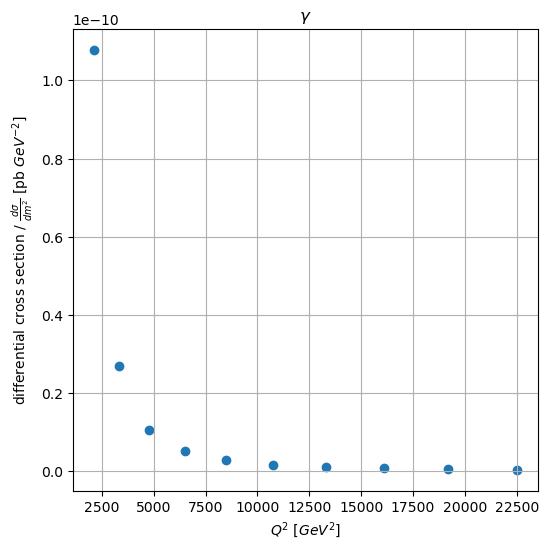

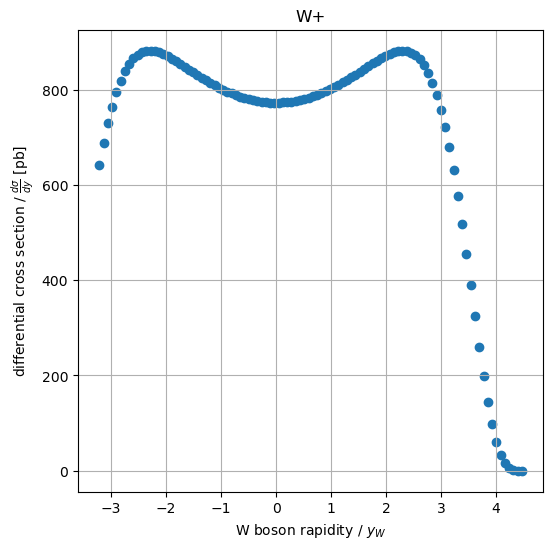

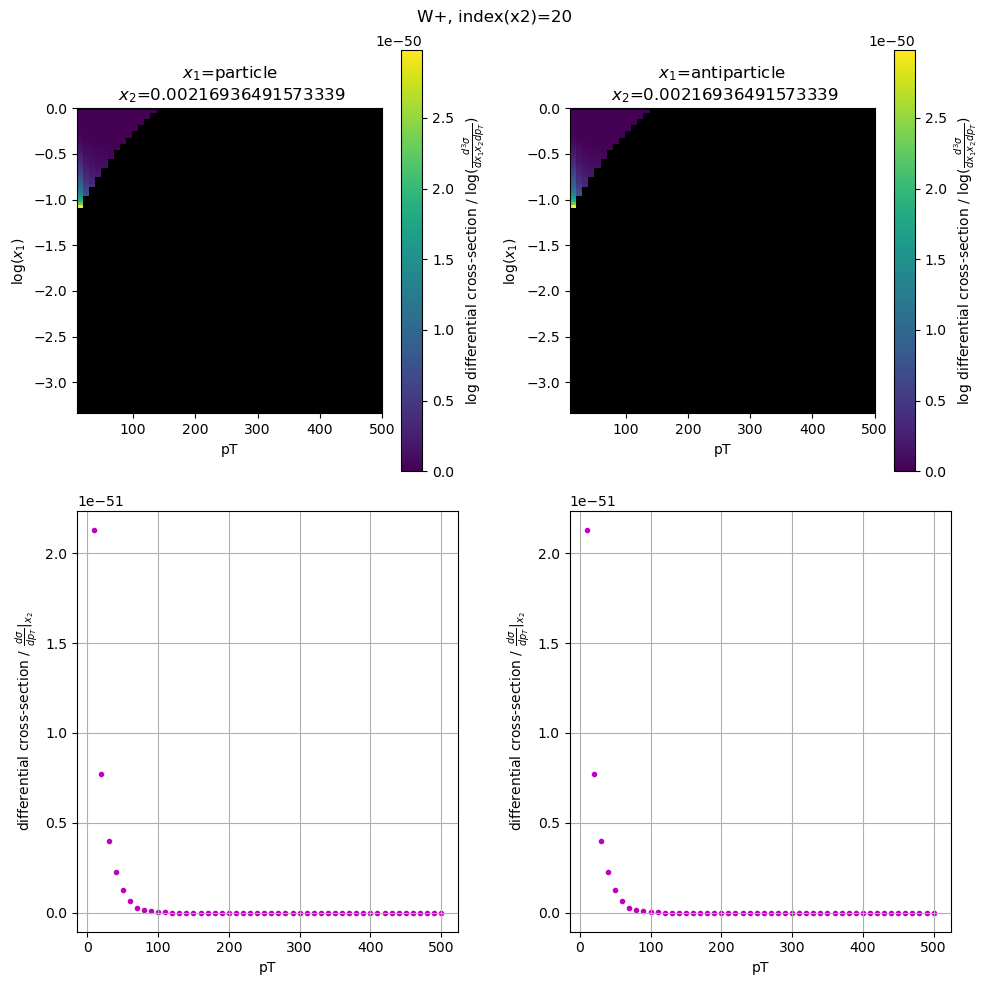

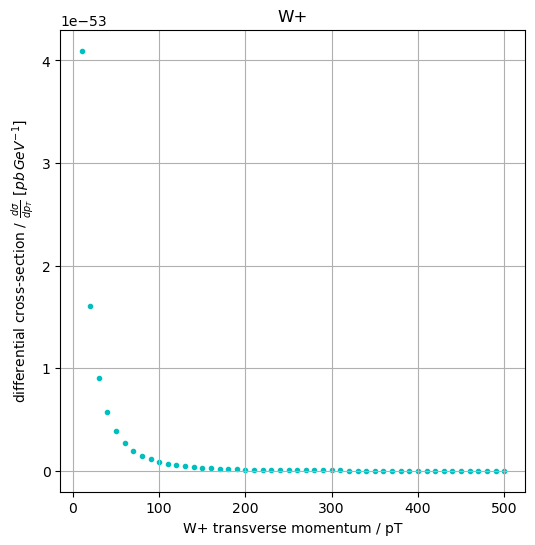

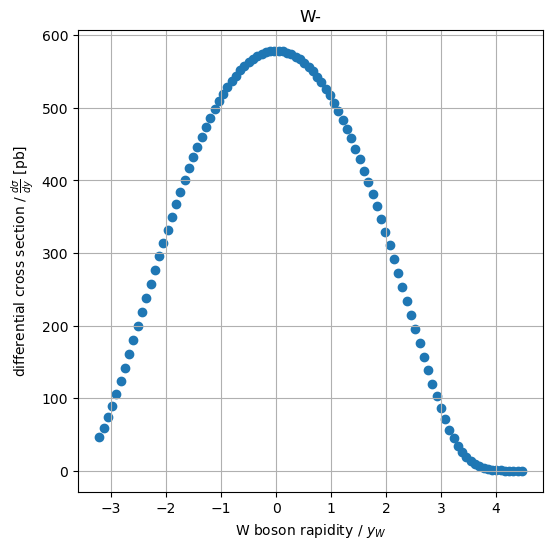

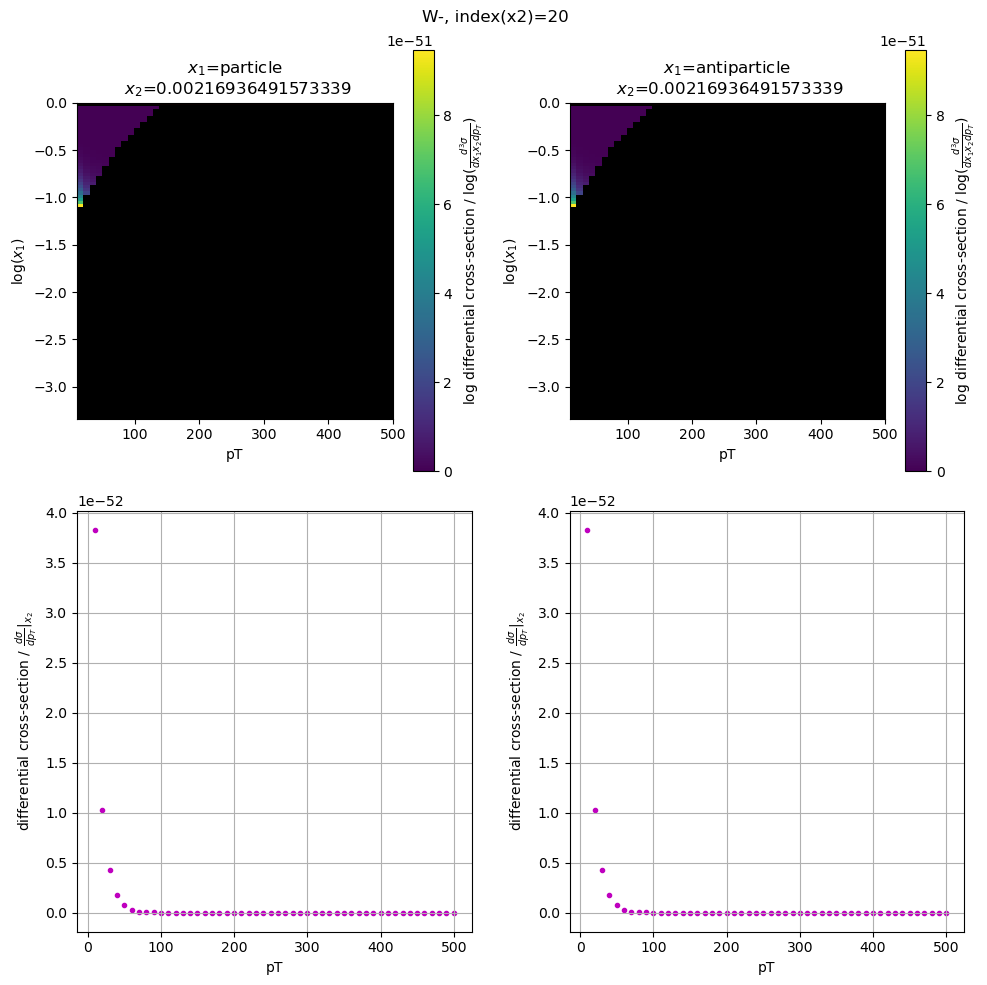

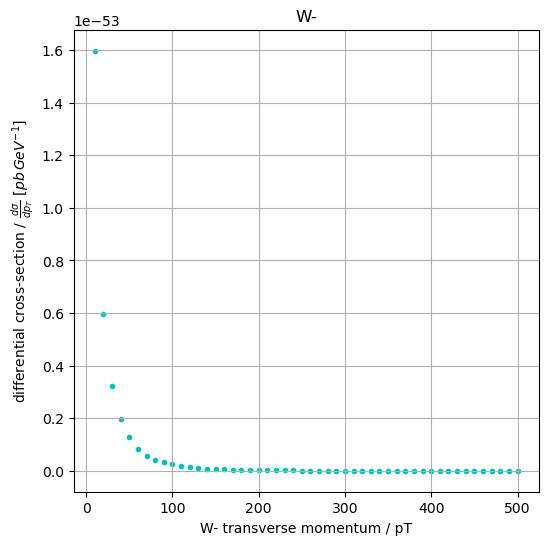

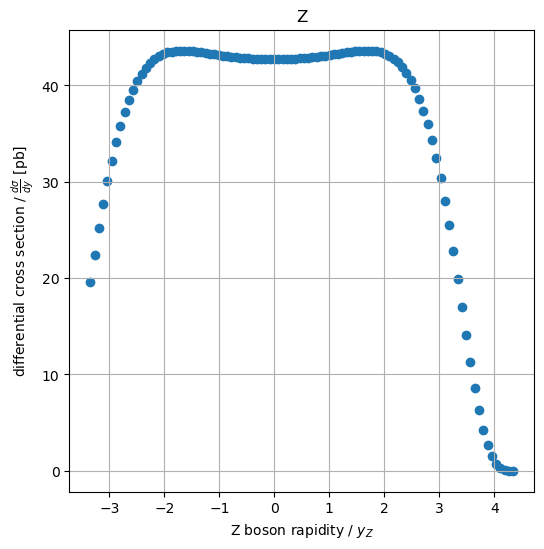


Cross-section ratios.


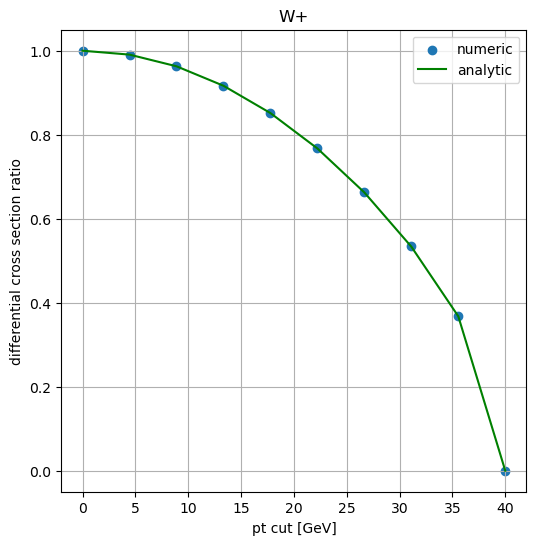

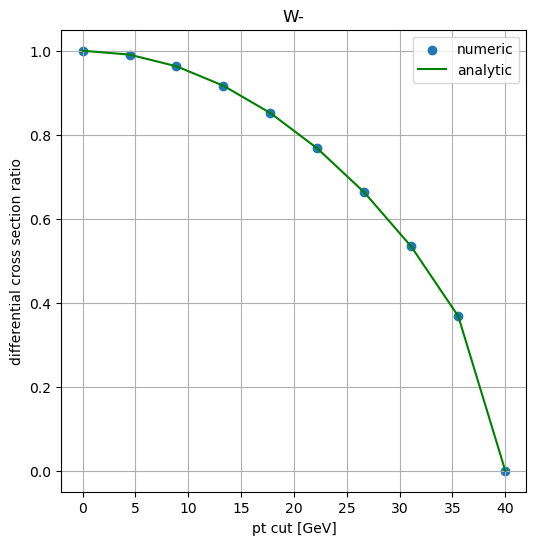


Integral visulisation.
+


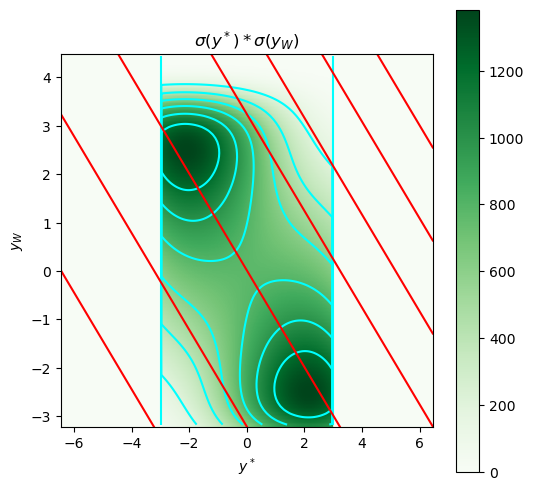

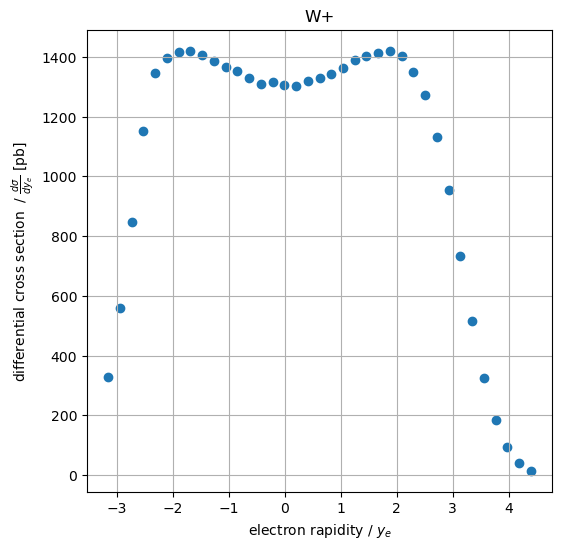

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.88s/it]


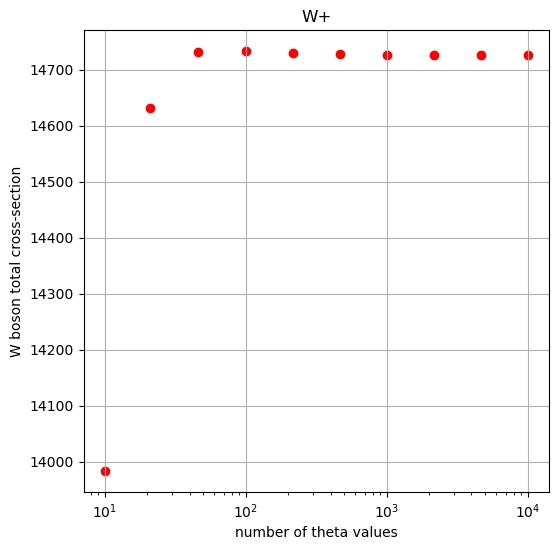

-


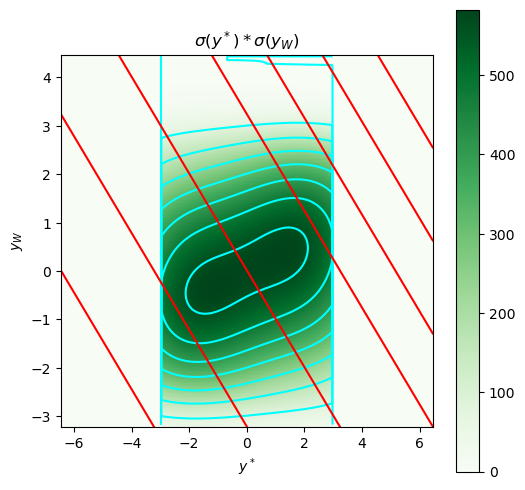

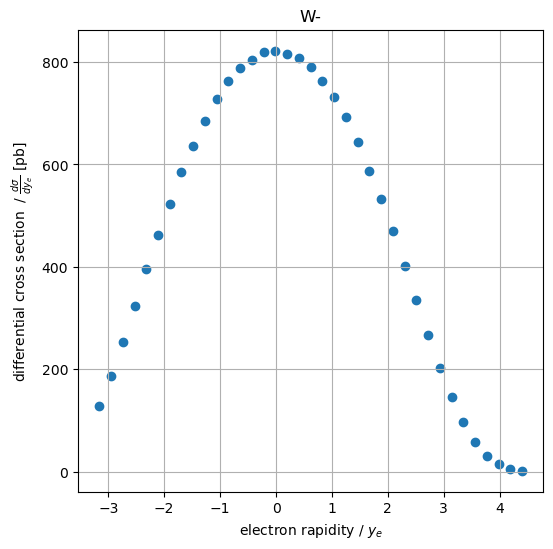

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.52s/it]


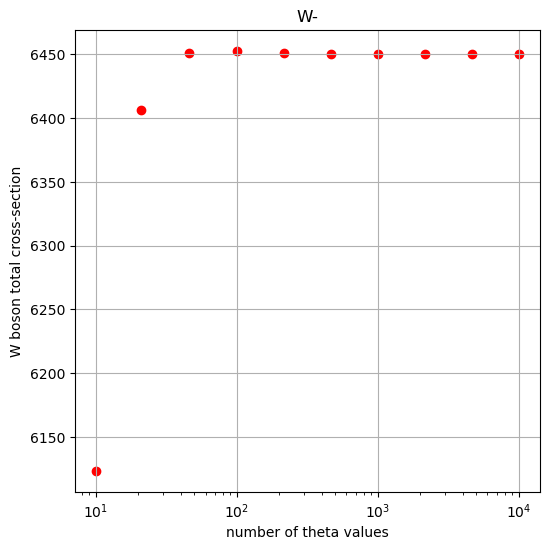

In [6]:
if __name__=='__main__':
    main()